In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tempfile import TemporaryDirectory
import time
from torch.optim import lr_scheduler


In [2]:
DATA_DIR = "data/ml-100k"

def read_data_ml100k(data_dir:str)->tuple[pd.DataFrame,int,int]:
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [3]:
data, num_users, num_items = read_data_ml100k(DATA_DIR)
sparsity:int = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


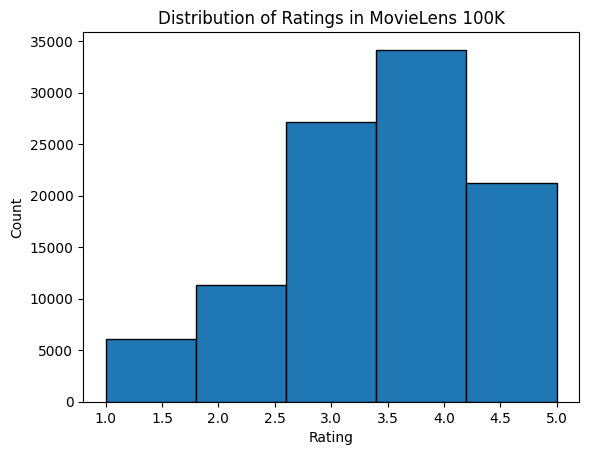

In [4]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [5]:
def split_data_ml100k(data: pd.DataFrame, num_users: int, num_items: int,
                      split_mode: str = 'random', test_ratio: float = 0.1) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataset into training and testing sets in either random mode or sequence-aware mode.

    Parameters:
    -----------
    data : pd.DataFrame
        The dataset containing user-item interactions. Expected columns are user_id, item_id, rating, and timestamp.
    num_users : int
        The number of unique users in the dataset.
    num_items : int
        The number of unique items in the dataset.
    split_mode : str, optional
        The mode of splitting the data. Can be 'random' or 'seq-aware'. Default is 'random'.
    test_ratio : float, optional
        The ratio of the dataset to be used as the test set. Only used if split_mode is 'random'. Default is 0.1.

    Returns:
    --------
    tuple[pd.DataFrame, pd.DataFrame]
        A tuple containing the training and testing datasets as pandas DataFrames.
    """
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def load_data_ml100k(data: pd.DataFrame, num_users: int, num_items: int, feedback: str = 'explicit') -> tuple[list[int], list[int], list[int], np.ndarray | dict]:
    """
    Load the dataset and convert it into user-item interaction matrices.

    Parameters:
    -----------
    data : pd.DataFrame
        The dataset containing user-item interactions. Expected columns are user_id, item_id, and rating.
    num_users : int
        The number of unique users in the dataset.
    num_items : int
        The number of unique items in the dataset.
    feedback : str, optional
        The type of feedback. Can be 'explicit' or 'implicit'. Default is 'explicit'.

    Returns:
    --------
    tuple[list[int], list[int], list[int], np.ndarray | dict]
        A tuple containing:
        - users: List of user indices.
        - items: List of item indices.
        - scores: List of scores (ratings or implicit feedback).
        - inter: User-item interaction matrix. If feedback is 'explicit', this is a 2D numpy array.
                 If feedback is 'implicit', this is a dictionary where keys are user indices and values are lists of item indices.
    """
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter


In [6]:
def split_and_load_ml100k_pytorch(data_dir:str,split_mode: str = 'seq-aware', feedback: str = 'explicit',
                                  test_ratio: float = 0.1, batch_size: int = 256)->tuple[int,int,DataLoader,DataLoader]:
    """
    Split the dataset and load it into PyTorch DataLoader objects.

    Parameters:
    -----------
    split_mode : str, optional
        The mode of splitting the data. Can be 'random' or 'seq-aware'. Default is 'seq-aware'.
    feedback : str, optional
        The type of feedback. Can be 'explicit' or 'implicit'. Default is 'explicit'.
    test_ratio : float, optional
        The ratio of the dataset to be used as the test set. Only used if split_mode is 'random'. Default is 0.1.
    batch_size : int, optional
        The size of the batches for the DataLoader. Default is 256.

    Returns:
    --------
    tuple[int, int, DataLoader, DataLoader]
        A tuple containing:
        - num_users: The number of unique users.
        - num_items: The number of unique items.
        - train_iter: DataLoader for the training set.
        - test_iter: DataLoader for the test set.
    """
    data, num_users, num_items = read_data_ml100k(data_dir)
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    
    # Convert to PyTorch tensors
    train_u_tensor = torch.tensor(train_u, dtype=torch.long)
    train_i_tensor = torch.tensor(train_i, dtype=torch.long)
    train_r_tensor = torch.tensor(train_r, dtype=torch.float)
    test_u_tensor = torch.tensor(test_u, dtype=torch.long)
    test_i_tensor = torch.tensor(test_i, dtype=torch.long)
    test_r_tensor = torch.tensor(test_r, dtype=torch.float)
    
    # Create TensorDataset
    train_set = TensorDataset(train_u_tensor, train_i_tensor, train_r_tensor)
    test_set = TensorDataset(test_u_tensor, test_i_tensor, test_r_tensor)
    
    # Create DataLoader
    train_iter = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_iter = DataLoader(test_set, batch_size=batch_size)
    
    return num_users, num_items, train_iter, test_iter

In [7]:
class MF(nn.Module):
    def __init__(self, num_factors: int, num_users: int, num_items: int):
        """
        Matrix Factorization model using PyTorch.

        Parameters:
        -----------
        num_factors : int
            The number of latent factors.
        num_users : int
            The number of unique users.
        num_items : int
            The number of unique items.
        """
        super(MF, self).__init__()
        # User latent matrix
        self.P = nn.Embedding(num_users, num_factors)
        # Item latent matrix
        self.Q = nn.Embedding(num_items, num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id: torch.Tensor, item_id: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the model.

        Parameters:
        -----------
        user_id : torch.Tensor
            Tensor containing user indices.
        item_id : torch.Tensor
            Tensor containing item indices.

        Returns:
        --------
        torch.Tensor
            Predicted ratings.
        """
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id).squeeze()
        b_i = self.item_bias(item_id).squeeze()
        outputs = (P_u * Q_i).sum(dim=1) + b_u + b_i
        return outputs

In [9]:
def train_model(net:MF,dataloaders:dict[str,DataLoader],dataset_sizes:dict[str,int],device:torch.device,optimizer:torch.optim.Optimizer,scheduler,num_epochs:int=25)->MF:
    """
    Train the Matrix Factorization (MF) model.

    Parameters:
    -----------
    net : MF
        The Matrix Factorization model to be trained.
    dataloaders : dict[str, DataLoader]
        A dictionary containing the DataLoader objects for training and validation datasets.
        Expected keys are 'train' and 'val'.
    dataset_sizes : dict[str, int]
        A dictionary containing the sizes of the training and validation datasets.
        Expected keys are 'train' and 'val'.
    device : torch.device
        The device to run the training on (e.g., 'cpu' or 'cuda').
    optimizer : Optimizer
        The optimizer to use for training.
    scheduler : _LRScheduler
        The learning rate scheduler to use for training.
    num_epochs : int, optional
        The number of epochs to train the model. Default is 25.

    Returns:
    --------
    MF
        The trained Matrix Factorization model with the best validation loss.
    """
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(net.state_dict(),best_model_params_path)
        best_loss = 99999999999
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    net.train()  # Set model to training mode
                else:
                    net.eval()   # Set model to evaluate mode
                
                running_loss = 0.0

                # Iterate over data.
                for user_batch, item_batch, rating_batch in dataloaders[phase]:
                    user_batch = user_batch.to(device)
                    item_batch = item_batch.to(device)
                    rating_batch = rating_batch.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = net(user_batch,item_batch)
                        # apply RMSE as loss function
                        criterion = nn.MSELoss()
                        loss = torch.sqrt(criterion(outputs, rating_batch))

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * user_batch.size(0)
                
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                print(f'{phase} Loss: {epoch_loss:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(net.state_dict(), best_model_params_path)
            print()
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best loss: {best_loss:4f}')

        # load best model weights
        net.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    
    return net

In [10]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")
    num_users, num_items, train_iter, test_iter = split_and_load_ml100k_pytorch(DATA_DIR,test_ratio=0.1, batch_size=512)
    
    dataloaders = {'train':train_iter, 'val':test_iter}
    dataset_sizes = {'train':len(train_iter.dataset),'val':len(test_iter.dataset)}
    

    model = MF(30,num_users,num_items).to(mps_device)
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    model = train_model(model,dataloaders,dataset_sizes,mps_device,optimizer,exp_lr_scheduler,num_epochs=50)


Epoch 0/49
----------
train Loss: 6.6057
val Loss: 6.5009

Epoch 1/49
----------
train Loss: 6.2512
val Loss: 6.2714

Epoch 2/49
----------
train Loss: 5.9118
val Loss: 6.0479

Epoch 3/49
----------
train Loss: 5.5871
val Loss: 5.8340

Epoch 4/49
----------
train Loss: 5.2762
val Loss: 5.6254

Epoch 5/49
----------
train Loss: 4.9782
val Loss: 5.4259

Epoch 6/49
----------
train Loss: 4.6936
val Loss: 5.2336

Epoch 7/49
----------
train Loss: 4.4209
val Loss: 5.0477

Epoch 8/49
----------
train Loss: 4.1588
val Loss: 4.8704

Epoch 9/49
----------
train Loss: 3.9091
val Loss: 4.6979

Epoch 10/49
----------
train Loss: 3.7500
val Loss: 4.6812

Epoch 11/49
----------
train Loss: 3.7262
val Loss: 4.6643

Epoch 12/49
----------
train Loss: 3.7027
val Loss: 4.6475

Epoch 13/49
----------
train Loss: 3.6785
val Loss: 4.6307

Epoch 14/49
----------
train Loss: 3.6547
val Loss: 4.6138

Epoch 15/49
----------
train Loss: 3.6304
val Loss: 4.5969

Epoch 16/49
----------
train Loss: 3.6066
val Loss